In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import os
import time
import json
import random
import numpy as np
import pandas as pd

from PIL import Image

In [2]:
devices = tf.config.experimental.list_physical_devices("GPU")
for device in devices:
    tf.config.experimental.set_memory_growth(device,enable=True)

In [3]:
annotation_folder = "./dataset/"
image_folder = "./dataset/image"

In [4]:
annotation_file = os.path.join(annotation_folder, "RESULTs.txt")
with open (annotation_file, "r",encoding="utf-8") as file:
    annotations = file.read()
    file.close()
annotations.split("\n")[1]

'1000092795.jpg#1\\tTwo young , White males are outside near many bushes .'

In [5]:
image_path_to_caption = collections.defaultdict(list)
for line in annotations.split('\n'):
    image_name=line.split("#")[0]
    caption=line.split("\\t")[-1]
    caption=f"<start> {caption} <end>"
    image_path=os.path.join(image_folder, image_name)
    if image_path.endswith(".jpg"):
        image_path_to_caption[image_path].append(caption)

In [6]:

image_path_to_caption[os.path.join(image_folder, "1000092795.jpg")]

['<start> Two young guys with shaggy hair look at their hands while hanging out in the yard . <end>',
 '<start> Two young , White males are outside near many bushes . <end>',
 '<start> Two men in green shirts are standing in a yard . <end>',
 '<start> A man in a blue shirt standing in a garden . <end>',
 '<start> Two friends enjoy time spent together . <end>']

In [7]:
train_image_paths=list(image_path_to_caption.keys())
random.shuffle(train_image_paths)
print(len(train_image_paths))

62


In [8]:
train_captions = []
image_name_vector = []

for image_path in train_image_paths:
    caption_list=image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    image_name_vector.extend([image_path]*len(caption_list))

In [9]:
print(train_captions[0])

<start> a boy in a blue top is jumping off some rocks in the woods . <end>


In [10]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image,image_path

In [11]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input=image_model.input
hidden_layer=image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input,hidden_layer)

In [12]:
encode_train = sorted(set(image_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image).batch(32)

In [13]:
from tqdm import tqdm
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_features = p.numpy().decode("utf-8")
        np.save(path_of_features,bf.numpy())

100%|██████████| 2/2 [00:36<00:00, 18.44s/it]


In [14]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [15]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = top_k,
                                                  oov_token="<unk>",
                                                  filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [16]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0]= '<pad>'

In [17]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [18]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs,padding="post")

In [19]:
max_length = calc_max_length(train_seqs)
max_length

34

In [20]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(image_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

In [21]:
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

In [22]:
img_name_train_keys[1]

'./dataset/image\\3094629328.jpg'

In [23]:
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

In [24]:
img_name_val, cap_val = [], []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [25]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(245, 245, 65, 65)

In [26]:
batch_size = 16
buffer_size = 500
embedding_dim = 256 
units = 512 
vocab_size= top_k + 1
num_steps = len(img_name_train)
features_shape = 2048
attention_features_shape= 16

In [27]:
def map_func(image_name, cap):
    img_tensor = np.load(image_name.decode("utf-8") + ".npy")
    return img_tensor,cap

In [28]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train,cap_train))

In [29]:
dataset=dataset.map(lambda item1, item2:tf.numpy_function(
    map_func, [item1, item2], [tf.float32,tf.int32]))

In [30]:
dataset=dataset.shuffle(buffer_size).batch(batch_size)

In [31]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super (BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers. Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        score = self.V(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights*features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [32]:
class CNN_Encoder(tf.keras.Model):

    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense (embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [33]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units= units
        self.embedding=tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru=tf.keras.layers.GRU(self.units,
                                     return_sequences=True,
                                     return_state=True,
                                     recurrent_initializer='glorot_uniform')

        self.fc1=tf.keras.layers.Dense(self.units)
        self.fc2=tf.keras.layers.Dense(vocab_size)
        
        self.attention=BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights=self.attention(features, hidden)
        x = self.embedding(x)
        x=tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state=self.gru(x)
        x=self.fc1(output)
        x= tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [34]:
encoder= CNN_Encoder(embedding_dim)
decoder= RNN_Decoder(embedding_dim, units, vocab_size)

In [35]:
optimizer = tf.keras.optimizers.Adam()
loss_object=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")

def loss_function(real, pred):
    mask=tf.math.logical_not(tf.math.equal(real, 0))
    loss_= loss_object(real, pred)
    mask= tf.cast(mask, dtype= loss_.dtype)
    loss_*= mask
    return tf.reduce_mean(loss_)

In [36]:
checkpoint_path="./checkpoints/train"
ckpt=tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train. CheckpointManager(ckpt, checkpoint_path,max_to_keep=5)

In [37]:
start_epoch=1
if ckpt_manager.latest_checkpoint:
    start_epoch=int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore (ckpt_manager.latest_checkpoint)

In [38]:
loss_plot=[]

In [39]:
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')


In [40]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    train_accuracy.reset_state()  # Corrected method name
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index["<start>"]] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            prediction, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], prediction)
            train_accuracy.update_state(target[:, i], prediction)
            dec_input = tf.expand_dims(target[:, i], 1)
    total_loss = loss / int(target.shape[1])
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss, train_accuracy.result()



In [41]:
# @tf.function
# def train_step(img_tensor, target):
#     loss=0
#     hidden= decoder.reset_state(batch_size=target.shape[0])
#     dec_input = tf.expand_dims([tokenizer.word_index["<start>"]] * target.shape[0], 1)

#     with tf.GradientTape() as tape:
#         features= encoder(img_tensor)
#         for i in range(1, target.shape[1]):
#             prediction, hidden,_ =decoder(dec_input, features, hidden)
#             loss += loss_function(target[:,i], prediction)
#             dec_input = tf.expand_dims(target[:, i], 1)
#     total_loss= (loss / int(target.shape[1]))
#     trainable_variables= encoder.trainable_variables + decoder.trainable_variables
#     gradients= tape.gradient(loss, trainable_variables)
#     optimizer.apply_gradients(zip(gradients, trainable_variables))

#     return loss, total_loss

In [42]:
epochs = 20

for epoch in range(start_epoch, epochs):
    start = time.time()
    total_loss = 0
    total_accuracy = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss, accuracy = train_step(img_tensor, target)
        total_loss += t_loss
        total_accuracy += accuracy

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy() / int(target.shape[1])
            print(f"Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f} Accuracy {accuracy:.4f}")

        loss_plot.append(total_loss / num_steps)
        if batch == 2000:
            break

    if epoch % 2 == 0:
        ckpt_manager.save()

    average_epoch_loss = total_loss / num_steps
    average_epoch_accuracy = total_accuracy / num_steps
    print(f"Epoch {epoch+1} Loss {average_epoch_loss:.6f} Accuracy {average_epoch_accuracy:.4f}")
    print(f"Time taken for 1 epoch {time.time() - start:.2f} sec\n")


Epoch 2 Batch 0 Loss 3.1885 Accuracy 0.0000
Epoch 2 Loss 0.156124 Accuracy 0.0021
Time taken for 1 epoch 98.42 sec

Epoch 3 Batch 0 Loss 1.9215 Accuracy 0.0492
Epoch 3 Loss 0.127479 Accuracy 0.0028
Time taken for 1 epoch 19.76 sec

Epoch 4 Batch 0 Loss 1.8094 Accuracy 0.0587
Epoch 4 Loss 0.124302 Accuracy 0.0031
Time taken for 1 epoch 17.61 sec

Epoch 5 Batch 0 Loss 1.5280 Accuracy 0.0568
Epoch 5 Loss 0.122455 Accuracy 0.0035
Time taken for 1 epoch 18.59 sec

Epoch 6 Batch 0 Loss 2.0788 Accuracy 0.0644
Epoch 6 Loss 0.117125 Accuracy 0.0042
Time taken for 1 epoch 17.65 sec

Epoch 7 Batch 0 Loss 1.6837 Accuracy 0.0871
Epoch 7 Loss 0.110746 Accuracy 0.0048
Time taken for 1 epoch 18.88 sec

Epoch 8 Batch 0 Loss 1.6607 Accuracy 0.0909
Epoch 8 Loss 0.104069 Accuracy 0.0052
Time taken for 1 epoch 18.98 sec

Epoch 9 Batch 0 Loss 1.4886 Accuracy 0.0890
Epoch 9 Loss 0.095100 Accuracy 0.0056
Time taken for 1 epoch 19.38 sec

Epoch 10 Batch 0 Loss 1.4224 Accuracy 0.1004
Epoch 10 Loss 0.086403 Accu

In [43]:
# epochs = 20

# for epoch in range(start_epoch, epochs):
#     start=time.time()
#     total_loss = 0
#     total_accuracy = 0


#     for (batch, (img_tensor, target)) in enumerate(dataset):
#         batch_loss, t_loss= train_step(img_tensor, target)
#         total_loss += t_loss

#         if batch % 100 == 0:
#             average_batch_loss = batch_loss.numpy() / int(target.shape[1])
#             print (f"Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}")

#         loss_plot.append(total_loss / num_steps)

#     if epoch % 2 == 0:
#         ckpt_manager.save()

#     print(f"Epoch {epoch+1 } Loss {total_loss / num_steps:.6f}")
#     print(f"Time taken for 1 epoch {time.time() - start: 2f} sec\n")

In [44]:
attention_features_shape = 64 
def evaluate(image):
    attention_plot= np.zeros((max_length, attention_features_shape))
    hidden= decoder.reset_state(batch_size=1)

    temp_input= tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val= image_features_extract_model(temp_input)
    img_tensor_val= tf.reshape(img_tensor_val,(img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features= encoder(img_tensor_val)
    dec_input= tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights= decoder(dec_input, features, hidden)

        attention_plot[i]= tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id= tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        dec_input= tf.expand_dims([predicted_id], 0)
    attention_plot= attention_plot[:len(result), :]

    return result, attention_plot

In [45]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img= ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent= img.get_extent())
    plt.tight_layout()
    plt.show()

Real Caption: <start> two men are at the stove preparing food <end>
Prediction Caption: a man in a street <end>


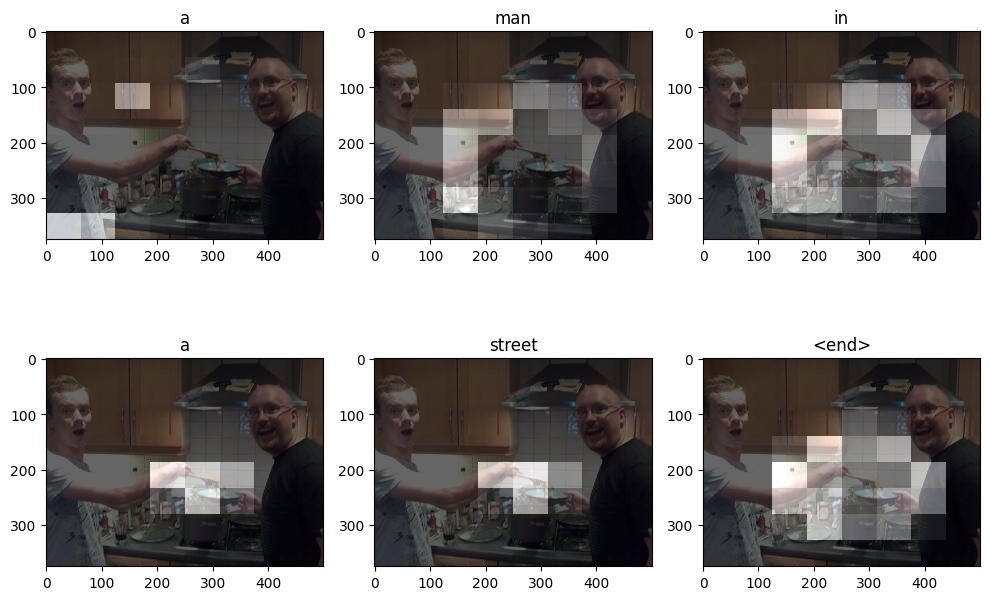

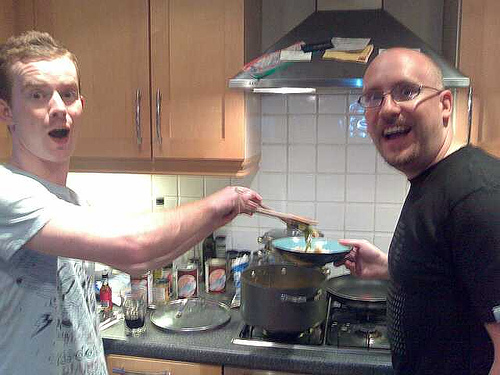

In [50]:
rid = np.random.randint(0, len(img_name_val))
image= img_name_val[rid]
real_caption=' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot= evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:',' '.join(result))

plot_attention(image, result, attention_plot)

Image.open(img_name_val[rid])

In [ ]:
image = 'test1.jpeg'
result, attention_plot = evaluate(image)
pridiction=' '.join(result)
print('Prediction Caption:', pridiction)

plot_attention(image, result, attention_plot)

Image.open(image)